In [1]:
# select the guide stars for GLAO for each field
# find the error due to noise
import warnings
warnings.filterwarnings("ignore")

import ceo
import yaml
from yaml import Loader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits
from astropy.coordinates import SkyCoord
import astropy.units as units
import atp
import copy
from agwsprobes import *
import scipy.interpolate
import os

plt.ion()

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
L=25.5
nPx = 201
nLenslet = 48
threshold = 0.5 # subaperture flux threshold
gmt = ceo.GMT_MX()

def modestogmtstate(gmt,modes):
    state = gmt.state

    M1Txyz = modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]]
    state['M1']['Txyz'] = np.reshape(M1Txyz,(7,3))

    M2Txyz = modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]]
    state['M2']['Txyz'] = np.reshape(M2Txyz,(7,3))

    M1Rxyz = np.zeros(21)
    M1Rxyz[0:20] = modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]]
    state['M1']['Rxyz'] = np.reshape(M1Rxyz,(7,3))
    
    M2Rxyz = np.zeros(21)
    M2Rxyz[0:20] = modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]]
    state['M2']['Rxyz'] = np.reshape(M2Rxyz,(7,3))
    gmt^=state

girmode = "tracking"
config = "dgwf"

In [3]:
simmag = [7,8,9,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]

if config == "dgnf":
    maxstarsperprobe = 8 # maximum number of stars per probe to analyze
    simstd = np.array([ 0.0040158,00.0061672,0.009668,0.01507,0.018989,0.02393,0.030295,0.03862,0.049384,0.06360,0.083843,0.1125,0.16063]) # 48x48 
if config == "dgwf":
    maxstarsperprobe = 12 
    simstd = np.array([0.0044123,0.0068237,0.01062,0.01679,0.021108,0.026594,\
0.033714,0.042872,0.05484,0.0711,0.093967,0.1288,0.18781])

interp_function = scipy.interpolate.interp1d(simmag,simstd,bounds_error=False)

In [4]:
# this contains information about the observation
cfg = yaml.load(open(os.path.expanduser('~/PYTHON/ATP/atp.yaml')),Loader)

# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

validator = agwsinit(config)

### most likely this is meant to loop over all 1000 fields. The py script is set up to look at fieldno=56 only, as an example. However field0056 has zero valid stars for one probe. So I switch to fieldno = 0

In [20]:
fieldno = 0

In [21]:
telzen = (90-telel[fieldno])*np.pi/180.
airmass = 1./np.cos(telzen)

cfg['Observation']['time'] = Time(datetime[fieldno] , format='decimalyear', scale='utc')
cfg['Target']['ra'] = scira[fieldno]
cfg['Target']['dec'] = scidec[fieldno]

cfg['Target']['pointing alt/az']['alt'][0] = telel[fieldno]
cfg['Target']['pointing alt/az']['az'][0] = telaz[fieldno]

cfg['Atmosphere']['r0'][0] = r0[fieldno]*100.
cfg['Atmosphere']['L0'][0] = L0[fieldno]

obs = atp.Observatory(**cfg['Observatory'],**cfg['Observation'])
target = atp.Target(obs,**cfg['Target'])

fielddir = "~/PYTHON/AGWS/Fields"
starfield = os.path.expanduser(fielddir+f"/field_{fieldno:04d}.csv")

In [22]:
outputfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/glao_{config}_asterism_{fieldno:04d}.csv'
probefunction = [None,None,None,None]
gsno = [None,None,None,None] # guide star number
vismaggs = [0,0,0,0]
xposgs = [0,0,0,0]
yposgs = [0,0,0,0]

stars  = atp.StarField(obs,target,field=starfield,**cfg['Star Catalog'])

vismag = 0.46*stars.I+0.54*stars.R
# remove stars that have an NaN for magnitude
valid = ~np.isnan(vismag)*(vismag <= 14.5) # limit of 14.5 for GLAO ####################
validpos = np.where(valid)[0]

xposarcsec = stars.local[0,:]*180./np.pi*3600
yposarcsec = stars.local[1,:]*180./np.pi*3600

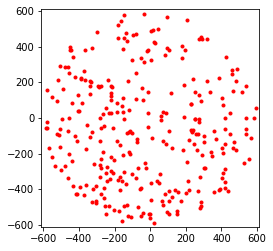

In [23]:
plt.figure(8)
plt.clf()
ax = plt.axes()
ax.set_aspect('equal')
plt.xlim((-610,610))
plt.ylim((-610,610))
plt.plot(xposarcsec[validpos],yposarcsec[validpos],'.',color='red')

In [24]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))
for k in range(len(xposarcsec)):
    if valid[k]:
        (success,loc,idx) = agwscheck(validator,gspos[[k],:])
        valid[k] = success

validpos = np.where(valid)[0]

print(len(validpos))

176


In [25]:
vismag = vismag[validpos]
xposarcsec = xposarcsec[validpos]
yposarcsec = yposarcsec[validpos]

Text(0, 0.5, 'Y-position (arcsec)')

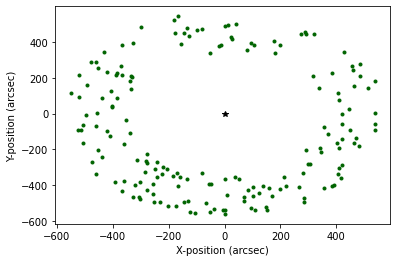

In [26]:
if config == "dgwf":
    minradarcsec = 365 # trial and error
    maxradarcsec = 572.4 # trial and error
if config == "dgnf":
    # the AGWS must be > 6' away to avoid vignetting the field
    minradarcsec = 364.7 
    maxradarcsec = 600
if config == "m3":
    # radius of guide star must be greater than 357.9 mm
    minradarcsec = 365.07
    maxradarcsec = 600

plt.plot(xposarcsec,yposarcsec,'.',color='darkgreen')
innercircle = plt.Circle([0,0],radius=minradarcsec,color='darkblue',fill=False)
ax.add_artist(innercircle)
outercircle = plt.Circle([0,0],radius=maxradarcsec,color='darkblue',fill=False)
ax.add_artist(outercircle)
plt.plot([0],[0],'*',color='black')

plt.xlabel('X-position (arcsec)')
plt.ylabel('Y-position (arcsec)')

In [27]:
gspos = np.transpose(np.array([xposarcsec,yposarcsec]))

# determine which probes reach which stars
probesreachstars = agwsreachstars(validator,gspos)

In [29]:
probesreachstars.shape

(4, 176)

In [30]:
# calculate the seeing 
gs_wavelength = Quantity(*cfg['SH']['guide star']['wavelength']).to('m').value
r0_wavelength = Quantity(*cfg['Atmosphere']['wavelength']).to('m').value
r0_val = Quantity(*cfg['Atmosphere']['r0']).to('m').value
r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
seeingRad = gs_wavelength/r0_val
seeingArcsec = seeingRad*ceo.constants.RAD2ARCSEC
print("seeing (arcsec) : %5.3f" %seeingArcsec)

probes_with_stars = probesreachstars.any(axis=1) 
n_probes_with_stars = np.sum(probes_with_stars)
print(n_probes_with_stars)

seeing (arcsec) : 0.757
4


In [31]:
s0 = np.where(probesreachstars[0,:])[0]
s1 = np.where(probesreachstars[1,:])[0]
s2 = np.where(probesreachstars[2,:])[0]
s3 = np.where(probesreachstars[3,:])[0]

# sort by magnitude and clip at maximum number
s0 = s0[np.argsort(vismag[s0])[0:maxstarsperprobe]]
s1 = s1[np.argsort(vismag[s1])[0:maxstarsperprobe]]
s2 = s2[np.argsort(vismag[s2])[0:maxstarsperprobe]]
s3 = s3[np.argsort(vismag[s3])[0:maxstarsperprobe]]

print(len(s0), len(s1),len(s2), len(s3))

12 12 12 12


In [32]:
# see which combinations are allowable
validasterisms = []
for k0 in s0:
    for k1 in s1:
        for k2 in s2:
            for k3 in s3:
                testpos = gspos[[k0,k1,k2,k3]]
                (success,loc,idx) = agwscheck(validator,testpos)
                if success and np.all(idx == np.array([0,1,2,3])):
                    validasterisms.append([k0,k1,k2,k3])

In [34]:
print(len(validasterisms))

604


In [35]:
validasterisms = np.array(validasterisms)

# now select the asterisms with the brightest stars
mags = vismag[validasterisms]

In [36]:
# there are various solutions to the problem
# 

# (1) We select the asterims whose fourth brightest star is the brightest. 
# (2) We weight all of the stars according to their noise. In this case, we want to maximimize the sum of 
#          1 divided by the noise terms.
# (3) We weight all of the stars equally. In this case, we minimize the sum of the noise terms

### Approach (1) ###
sortedmags = np.sort(mags,axis=1)
idx3 = np.where(sortedmags[:,3] == np.min(sortedmags[:,3]))[0]

if len(idx3) == 1:
    idx = idx3[0]
else:
    # asterisms with fourth brightest star of equal magnitudes
    idx2 = idx3[np.where(sortedmags[idx3,2] == np.min(sortedmags[idx3,2]))[0]]
    if len(idx2) == 1:
        idx = idx2[0]
    else:
        idx1 = idx2[np.where(sortedmags[idx2,1] == np.min(sortedmags[idx2,1]))[0]]
        if len(idx1) == 1:
            idx = idx1[0]
        else:
            idx0 = idx1[np.where(sortedmags[idx1,0] == np.min(sortedmags[idx1,0]))[0]]
            idx = idx0[0]

In [44]:
#no surprise that idx is 0, because we already sorted mags in s0,s1,s2,s3
idx3

array([0])

In [45]:
idx

0

In [46]:
# calculate the reconstructor with this asterism
vidx = validasterisms[idx]
xpos = xposarcsec[vidx]
ypos = yposarcsec[vidx]    
mag = vismag[vidx]

# save the position and magnitude of the guide stars
bestasterism = {'Probe number': [0,1,2,3],'Guide star':vidx,'Visible magnitude':mag,'xpos':xpos,'ypos':ypos,'selection':'brightest faint star'}

df = pd.DataFrame(bestasterism,index=None)
print (df)
df.to_csv(outputfilename, index = False, header=True, mode='w')

   Probe number  Guide star  Visible magnitude        xpos        ypos  \
0             0         138          10.658705 -460.046402  287.183803   
1             1         100           9.777500 -495.271642   -6.083056   
2             2         132          10.709084  -39.535994 -532.952254   
3             3         142           9.186929  537.977011  -91.433587   

              selection  
0  brightest faint star  
1  brightest faint star  
2  brightest faint star  
3  brightest faint star  


In [47]:
outputfilename

'/home/ubuntu/PYTHON/AGWS/Fields/glao_dgwf_asterism_0000.csv'

In [48]:
### Approach (2) ###

# for each asterism, evaluate the noise variance
noiserms = interp_function(np.clip(mags,7,14.5))    

totalnoise = 1./(np.sum(1./noiserms**2,axis=1))        
tidx = validasterisms[np.argsort(totalnoise)[0]]

xpos = xposarcsec[tidx]
ypos = yposarcsec[tidx]    
mag = vismag[tidx]

In [49]:
noiserms.shape

(604, 4)

In [50]:
totalnoise.shape

(604,)

In [51]:
tidx #note this gets us the same asterism as approach 1

array([138, 100, 132, 142])

In [52]:
# save the position and magnitude of the guide stars
bestasterism = {'Probe number': [0,1,2,3],'Guide star':tidx,'Visible magnitude':mag,'xpos':xpos,'ypos':ypos,'rec':'optimal weight '}

df = pd.DataFrame(bestasterism,index=None)
print (df)
df.to_csv(outputfilename, index = False, header=False, mode='a')

   Probe number  Guide star  Visible magnitude        xpos        ypos  \
0             0         138          10.658705 -460.046402  287.183803   
1             1         100           9.777500 -495.271642   -6.083056   
2             2         132          10.709084  -39.535994 -532.952254   
3             3         142           9.186929  537.977011  -91.433587   

               rec  
0  optimal weight   
1  optimal weight   
2  optimal weight   
3  optimal weight   


In [53]:
#approach 3

totalnoise = np.sum(noiserms**2,axis=1)        
qidx = validasterisms[np.argsort(totalnoise)[0]]

xpos = xposarcsec[qidx]
ypos = yposarcsec[qidx]    
mag = vismag[qidx]

# save the position and magnitude of the guide stars
bestasterism = {'Probe number': [0,1,2,3],'Guide star':qidx,'Visible magnitude':mag,'xpos':xpos,'ypos':ypos,'rec':'equal weight '}

df = pd.DataFrame(bestasterism,index=None)
print (df)
df.to_csv(outputfilename, index = False, header=False, mode='a')

   Probe number  Guide star  Visible magnitude        xpos        ypos  \
0             0         138          10.658705 -460.046402  287.183803   
1             1         100           9.777500 -495.271642   -6.083056   
2             2         132          10.709084  -39.535994 -532.952254   
3             3         142           9.186929  537.977011  -91.433587   

             rec  
0  equal weight   
1  equal weight   
2  equal weight   
3  equal weight   
